In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from time import time


env = gym.make("FrozenLake-v1", is_slippery=False)
env = env.unwrapped  

n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"Số trạng thái: {n_states}, Số hành động: {n_actions}")



Số trạng thái: 16, Số hành động: 4


In [2]:
def value_iteration(env, gamma=0.99, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)
    iteration = 0

    while True:
        delta = 0
        for s in range(env.observation_space.n):
            A = np.zeros(env.action_space.n)
            for a in range(env.action_space.n):
                for prob, next_s, reward, done in env.P[s][a]:
                    A[a] += prob * (reward + gamma * V[next_s])
            best_action_value = np.max(A)
            delta = max(delta, np.abs(V[s] - best_action_value))
            V[s] = best_action_value
            policy[s] = np.argmax(A)
        iteration += 1
        if delta < theta:
            break

    return V, policy, iteration


In [3]:
import cvxpy as cp

def solve_lp(env, gamma=0.99):
    V = cp.Variable(n_states)
    constraints = []

    for s in range(n_states):
        for a in range(n_actions):
            rhs = 0
            for prob, next_s, reward, done in env.P[s][a]:
                rhs += prob * (reward + gamma * V[next_s])
            constraints.append(V[s] >= rhs)

    objective = cp.Minimize(cp.sum(V))
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return V.value


In [4]:
def q_learning(env, episodes=20000, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.1, decay=0.9995):
    Q = np.zeros((n_states, n_actions))
    for ep in range(episodes):
        s, _ = env.reset()
        done = False

        while not done:
            # Epsilon-greedy
            if np.random.rand() < epsilon:
                a = np.random.randint(n_actions)
            else:
                a = np.argmax(Q[s])

            next_s, reward, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            best_next = np.max(Q[next_s])
            Q[s, a] += alpha * (reward + gamma * best_next - Q[s, a])
            s = next_s

        # Giảm epsilon dần
        epsilon = max(epsilon_min, epsilon * decay)

        # In log
        if ep % 5000 == 0:
            print(f"Episode {ep}, epsilon = {epsilon:.3f}")

    return Q, np.argmax(Q, axis=1)


def evaluate_policy(env, policy, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            a = policy[s]
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_reward += r
        total_rewards.append(ep_reward)
    return np.mean(total_rewards)


In [5]:
# Chạy từng thuật toán
V_vi, pi_vi, iter_vi = value_iteration(env)
V_lp = solve_lp(env)
Q_qlearn, pi_qlearn = q_learning(env)


Episode 0, epsilon = 1.000
Episode 5000, epsilon = 0.100
Episode 10000, epsilon = 0.100
Episode 15000, epsilon = 0.100


In [6]:
# In kết quả
print("Value Iteration:", V_vi.round(3))
print("Policy:", pi_vi)

Value Iteration: [0.951 0.961 0.97  0.961 0.961 0.    0.98  0.    0.97  0.98  0.99  0.
 0.    0.99  1.    0.   ]
Policy: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]


In [7]:
print("LP Solution:    ", V_lp.round(3))
print("Q-Learning:     ", np.max(Q_qlearn, axis=1).round(3))

LP Solution:     [ 0.951  0.961  0.97   0.961  0.961  0.     0.98   0.     0.97   0.98
  0.99   0.     0.     0.99   1.    -0.   ]
Q-Learning:      [0.951 0.961 0.97  0.959 0.961 0.    0.98  0.    0.97  0.98  0.99  0.
 0.    0.99  1.    0.   ]


In [8]:
Q, pi = q_learning(env)
print("Giá trị Q tối đa:", np.max(Q, axis=1).round(3))
print("Chính sách học được:", pi)

score = evaluate_policy(env, pi)
print(f"Reward trung bình đạt được (trên 100 episode): {score:.2f}")


Episode 0, epsilon = 1.000
Episode 5000, epsilon = 0.100
Episode 10000, epsilon = 0.100
Episode 15000, epsilon = 0.100
Giá trị Q tối đa: [0.951 0.961 0.97  0.92  0.961 0.    0.98  0.    0.97  0.98  0.99  0.
 0.    0.99  1.    0.   ]
Chính sách học được: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
Reward trung bình đạt được (trên 100 episode): 1.00


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


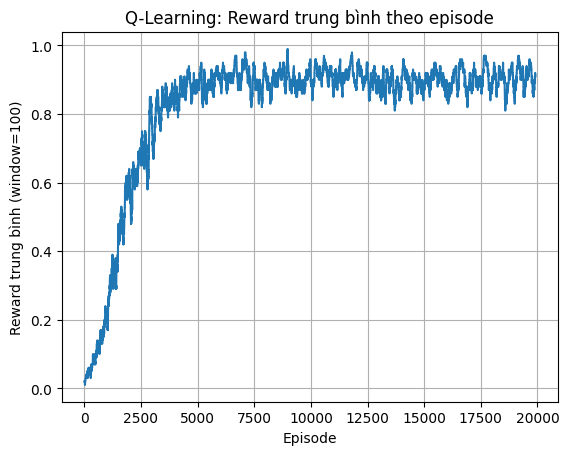

In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("FrozenLake-v1", is_slippery=False)
n_states = env.observation_space.n
n_actions = env.action_space.n

def q_learning(env, episodes=20000, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.1, decay=0.9995):
    Q = np.zeros((n_states, n_actions))
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        if isinstance(s, tuple): s = s[0]  # fix nếu là gymnasium
        done = False
        total_r = 0
        while not done:
            a = np.random.randint(n_actions) if np.random.rand() < epsilon else np.argmax(Q[s])
            next_s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r
            Q[s, a] += alpha * (r + gamma * np.max(Q[next_s]) - Q[s, a])
            s = next_s
        epsilon = max(epsilon_min, epsilon * decay)
        rewards.append(total_r)
    return Q, np.argmax(Q, axis=1), rewards


# Train và vẽ
Q, policy_q, rewards_q = q_learning(env)
plt.plot(np.convolve(rewards_q, np.ones(100)/100, mode='valid'))
plt.title("Q-Learning: Reward trung bình theo episode")
plt.xlabel("Episode")
plt.ylabel("Reward trung bình (window=100)")
plt.grid(True)
plt.show()


In [10]:
import time
import cvxpy as cp
import pandas as pd

# Value Iteration
def value_iteration(env, gamma=0.99, theta=1e-8):
    V = np.zeros(n_states)
    pi = np.zeros(n_states, dtype=int)
    iters = 0
    while True:
        delta = 0
        for s in range(n_states):
            A = np.zeros(n_actions)
            for a in range(n_actions):
                for p, ns, r, _ in env.P[s][a]:
                    A[a] += p * (r + gamma * V[ns])
            delta = max(delta, abs(V[s] - np.max(A)))
            V[s] = np.max(A)
            pi[s] = np.argmax(A)
        iters += 1
        if delta < theta: break
    return V, pi, iters

# LP (Primal)
def solve_lp(env, gamma=0.99):
    V = cp.Variable(n_states)
    constraints = []
    for s in range(n_states):
        for a in range(n_actions):
            expr = sum(p * (r + gamma * V[ns]) for p, ns, r, _ in env.P[s][a])
            constraints.append(V[s] >= expr)
    prob = cp.Problem(cp.Minimize(cp.sum(V)), constraints)
    prob.solve()
    return V.value

# Evaluate policy
def evaluate_policy(env, pi, episodes=100):
    total = 0
    for _ in range(episodes):
        s = env.reset()
        if isinstance(s, tuple): s = s[0]  # xử lý với Gym >= 0.26
        done = False
        while not done:
            s_, r, terminated, truncated, _ = env.step(pi[s])
            done = terminated or truncated
            total += r
            s = s_
    return total / episodes


# Chạy tất cả
start = time.time()
V_vi, pi_vi, it_vi = value_iteration(env)
t_vi = time.time() - start

start = time.time()
V_lp = solve_lp(env)
t_lp = time.time() - start

start = time.time()
Q, pi_q, rewards_q = q_learning(env)
t_ql = time.time() - start

# Đánh giá
r_vi = evaluate_policy(env, pi_vi)
r_q = evaluate_policy(env, pi_q)

# Bảng
df = pd.DataFrame({
    "Thuật toán": ["Value Iteration", "LP (Primal)", "Q-Learning"],
    "Thời gian (giây)": [t_vi, t_lp, t_ql],
    "Số vòng lặp / Episode": [it_vi, "-", "20000"],
    "Reward trung bình": [r_vi, r_vi, r_q]
})
print(df)


        Thuật toán  Thời gian (giây) Số vòng lặp / Episode  Reward trung bình
0  Value Iteration          0.000000                     7                1.0
1      LP (Primal)          0.039739                     -                1.0
2       Q-Learning          1.380241                 20000                1.0


In [11]:
import numpy as np
from scipy.optimize import linprog

# Định nghĩa MDP minh họa
S = list(range(5))   # các trạng thái 0,1,2,3,4
A = [0,1]            # hai hành động
gamma = 0.9
# Định nghĩa R và P
R = {}
P = {}
for s in S:
    R[(s,0)] = s              # hành động 0: ở nguyên, phần thưởng = s
    P[(s,0)] = {s: 1.0}       # xác suất 1 ở lại s
    R[(s,1)] = 0              # hành động 1: chuyển sang (s+1)%5, phần thưởng 0
    P[(s,1)] = {(s+1)%5: 1.0}

# Giải LP chính xác (biến V[0..4])
n = len(S)
c = np.ones(n)  # mục tiêu minimize sum V(s)
A_ub = []
b_ub = []
for s in S:
    for a in A:
        row = np.zeros(n)
        row[s] -= 1
        for s2, p in P[(s,a)].items():
            row[s2] += gamma * p
        b = -R[(s,a)]
        A_ub.append(row)
        b_ub.append(b)
res_exact = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=[(None,None)]*n, method='highs')
V_exact = res_exact.x
print("Giá trị chính xác V*:", np.round(V_exact, 3))

# Giải ALP với 2 tính năng: phi0=1, phi1=s
c_alp = np.array([5.0, 10.0])  # objective: sum V(s) = 5*w0 + 10*w1
A_ub_alp = []
b_ub_alp = []
for s in S:
    for a in A:
        if a == 0:
            s2 = s
            r = R[(s,a)]
        else:
            s2 = (s+1)%5
            r = R[(s,a)]
        # Constraint: (1-gamma)*w0 + (s - gamma*s2)*w1 >= r
        row = np.zeros(2)
        row[0] = -(1-gamma)
        row[1] = -(s - gamma*s2)
        A_ub_alp.append(row)
        b_ub_alp.append(-r)
res_alp = linprog(c_alp, A_ub=np.array(A_ub_alp), b_ub=np.array(b_ub_alp), bounds=[(None,None),(None,None)], method='highs')
w0, w1 = res_alp.x
V_alp = [w0 + w1*s for s in S]
print("Giá trị ALP:", np.round(V_alp,3))

# Giải NP-ALP với L = 10
L = 10.0
A_ub_np = []
b_ub_np = []
for s in S:
    for a in A:
        row = np.zeros(n)
        row[s] -= 1
        for s2,p in P[(s,a)].items():
            row[s2] += gamma*p
        b = -R[(s,a)]
        A_ub_np.append(row)
        b_ub_np.append(b)
for i in S:
    for j in S:
        if i == j: continue
        # Constraint: V(i) - V(j) <= L*|i-j|
        row = np.zeros(n)
        row[i] = 1
        row[j] = -1
        A_ub_np.append(row)
        b_ub_np.append(L * abs(i-j))
res_npalp = linprog(c, A_ub=np.array(A_ub_np), b_ub=np.array(b_ub_np), bounds=[(None,None)]*n, method='highs')
V_npalp = res_npalp.x
print("Giá trị NP-ALP:", np.round(V_npalp,3))


Giá trị chính xác V*: [26.244 29.16  32.4   36.    40.   ]
Giá trị ALP: [27.692 30.769 33.846 36.923 40.   ]
Giá trị NP-ALP: [26.244 29.16  32.4   36.    40.   ]
